In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import yfinance as yf

In [30]:
df = yf.download('BABA', start='2010-01-01', end='2025-07-10')

[*********************100%***********************]  1 of 1 completed


In [31]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [32]:
# # Load and prepare the dataset
# file_path = 'TSLA.csv'  # Make sure to have your dataset ready
# df = pd.read_csv(file_path)
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Parameters
time_step = 100
training_size = int(len(data_scaled) * 0.67)
test_size = len(data_scaled) - training_size 
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [33]:
X_train.shape

(1718, 100)

In [34]:
# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [35]:
X_train.shape

(1718, 100, 1)

In [36]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ input_layer_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 1)    │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 100, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 1)    │          0 │ dropout_5[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100, 4)    │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 100, 4)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 100, 1)    │          5 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 100, 1)    │          0 │ dense_5[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 20)        │      2,020 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         21 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,227 (36.04 KB)

 Trainable params: 9,227 (36.04 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0017 - val_loss: 6.3785e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0018 - val_loss: 6.5674e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0017 - val_loss: 6.2404e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0015 - val_loss: 6.4132e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0017 - val_loss: 6.1488e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0016 - val_loss: 5.9840e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0017 - val_loss: 6.2240e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0016 - val_loss: 6.3875e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0016 - val_loss: 6.5281e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0017 - val_loss: 6.0943e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0018 - val_loss: 6.1499e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━

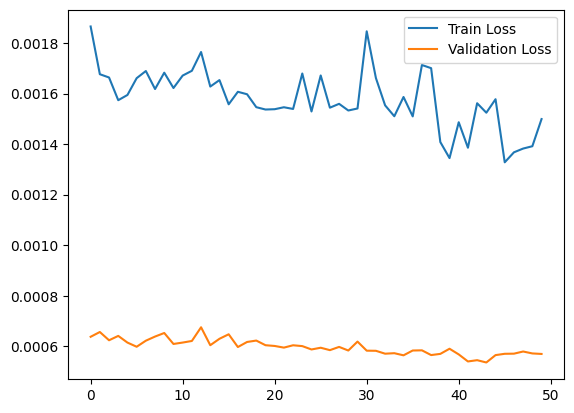

In [50]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [38]:
model.save('BABA_forecast.keras')

In [9]:
model.load_weights('BABA.keras')

c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Train RMSE: 40391.059630228505
Test RMSE: 22825.656814372043


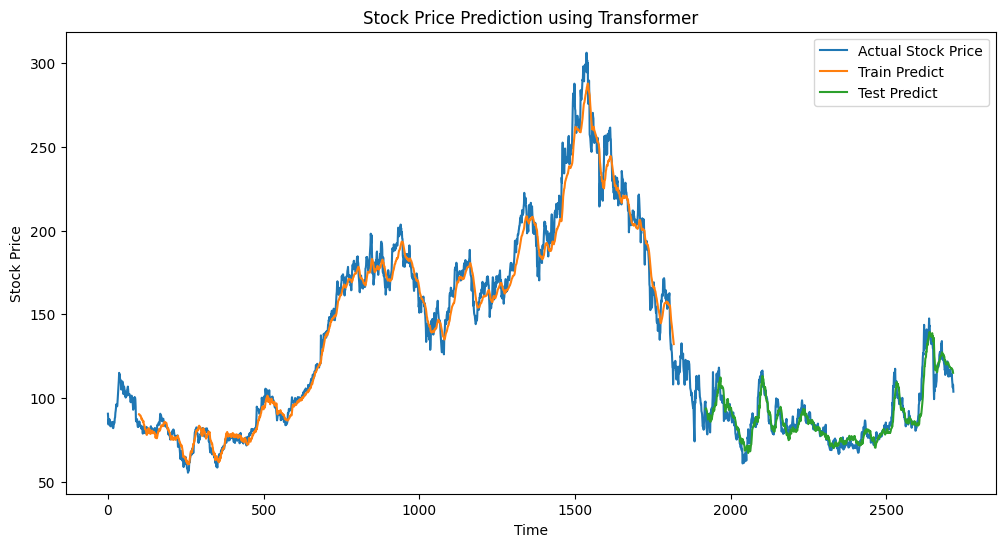

In [39]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Evaluate the model (Optional: Calculate RMSE or other metrics)
train_rmse = math.sqrt(mean_squared_error(y_train, scaler.inverse_transform(train_predict.reshape(-1, 1))))
test_rmse = math.sqrt(mean_squared_error(y_test, scaler.inverse_transform(test_predict.reshape(-1, 1))))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [11]:
df_pred = yf.download('BABA', start='2023-10-01', end='2025-03-01')

[*********************100%***********************]  1 of 1 completed


In [12]:
data_pred = df_pred[['Close']].values
data_pred_scaled = scaler.transform(data_pred)
X_pred, y_pred = create_dataset(data_pred_scaled, time_step)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

In [13]:
X_pred.shape

(253, 100, 1)

In [14]:
future_preds = model.predict(X_pred)
# Inverse transform future predictions  
future_preds = scaler.inverse_transform(future_preds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [15]:
futurePredictPlot = np.empty_like(data_pred_scaled)
futurePredictPlot[:, :] = np.nan

In [16]:
futurePredictPlot.shape

(354, 1)

In [17]:
# Say you want to put the predictions at the end of the plot
start = len(data_pred_scaled) - len(future_preds)
futurePredictPlot[start:, :] = future_preds

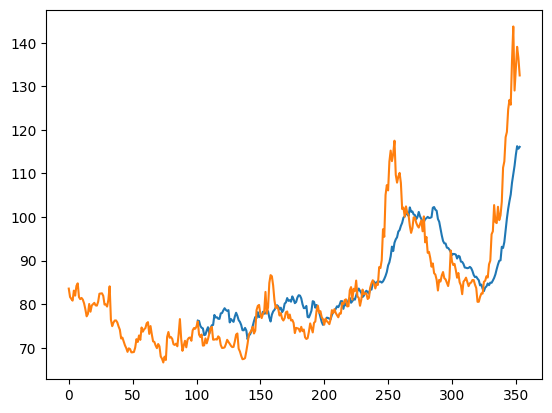

In [18]:
plt.plot(futurePredictPlot, label='Future Predictions')
plt.plot(data_pred, label='Actual Future Prices')

In [40]:
# Forecast future prices beyond the test set
n_future = 100  
last_sequence = data_scaled[-time_step:]  
future_forecasts = []

current_seq = last_sequence.copy()
for _ in range(n_future):
    input_seq = current_seq.reshape(1, time_step, 1)
    next_pred = model.predict(input_seq, verbose=0)
    future_forecasts.append(next_pred[0, 0])
    # Append the prediction and remove the first value to maintain the window
    current_seq = np.append(current_seq[1:], next_pred, axis=0)

future_forecasts = np.array(future_forecasts).reshape(-1, 1)
future_forecasts = scaler.inverse_transform(future_forecasts)

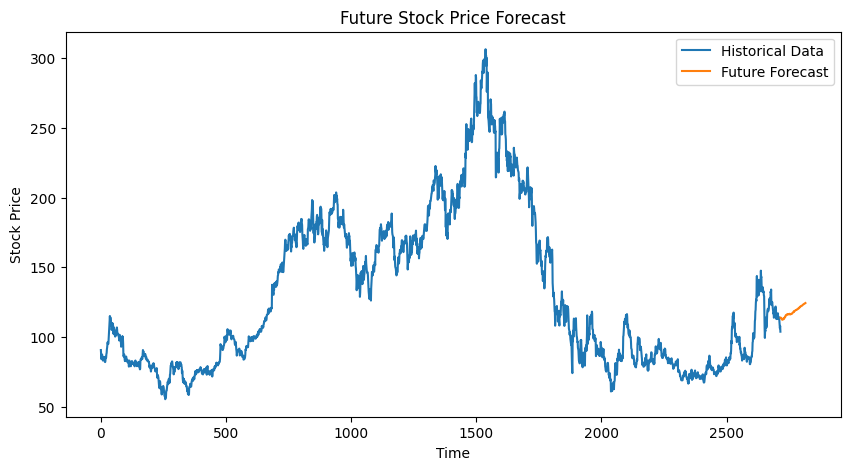

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(data)), scaler.inverse_transform(data_scaled), label='Historical Data')
plt.plot(np.arange(len(data), len(data) + n_future), future_forecasts, label='Future Forecast')
# plt.plot(df_pred["Close"][:100], label='Future Actual')
plt.title('Future Stock Price Forecast')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()